In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
import time
import functools
import cv2
import imutils
import IPython.display as display

### Preprocessing

In [2]:
content_img = Image.open('/content/dog.jpg')
style_img = Image.open('/content/Kandinsky.jpg')

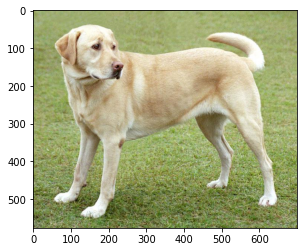

In [3]:
plt.imshow(content_img)

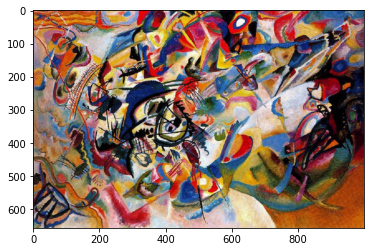

In [4]:
plt.imshow(style_img)

In [5]:
def process_img(img):
    x = np.array(img)
    x = imutils.resize(x, width=512) #set 512 to be maximum dimension
    x = tf.convert_to_tensor(x)
    x = tf.cast(x, tf.float32)
    x = x[tf.newaxis, :]                    #4 dim tensor
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

In [6]:
content_tensor = process_img(content_img)
style_tensor = process_img(style_img)

### Load VGG19 model and check its normal outputs

In [7]:
test_tensor = process_img(content_img)
test_tensor = tf.image.resize(test_tensor, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prob = vgg(test_tensor)
prob.shape

TensorShape([1, 1000])

In [8]:
predictions_top5 = tf.keras.applications.vgg19.decode_predictions(prob.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predictions_top5]

[('Labrador_retriever', 0.48956624),
 ('golden_retriever', 0.23806617),
 ('kuvasz', 0.03517462),
 ('Chesapeake_Bay_retriever', 0.025454897),
 ('Greater_Swiss_Mountain_dog', 0.01896047)]

### Load VGG19 without top, inspect the lower layers

In [9]:
VGG19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in VGG19.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Choose layers for style and content

In [10]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
                
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Building the model

In [11]:
#Use functional API of Keras

##### Function to build the model with selected content and style layers
##### Will return outputs of all selected intermediate layers

In [12]:
def get_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable=False

    style_outputs = [vgg.get_layer(layer).output for layer in style_layers]
    content_outputs = [vgg.get_layer(layer).output for layer in content_layers]

    model_outputs = style_outputs + content_outputs
    model = tf.keras.Model(vgg.input, model_outputs) #specify intermediate layers to also be outputs, so model will return a LIST of outputs(TENSORS)
    return model

In [13]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
Resnet = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
Resnet.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Content Loss : Eucledian distance between feature representations
Simply defined as the Eucledian distance between the Original feature maps in intermediate layers and the new feature maps.

$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

$F^l(x)$ is the feature representation of the $l^{th}$ layer (All kernels of that layer flattened into rows and lined up from top to bottom)

$F^l(x)$ is [$N^{l}$*M]. (M is the area of the kernel)

In [15]:
def get_content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content)) #tf.reduce_mean if given no params, sums across all rows and columns

### Style Loss: Square distance between the Gram Matrix representations
$$G^l_{ij} = \frac{\sum_{k} F^l_{ik}(x)F^l_{jk}(x)}{IJ}$$ 

Describes style correlation between feature maps

Instead of flattening all the feature maps and making a matrix F_ij for layer l, and then taking its gram product, we can directly use Einsum from numpy.
More explanation: https://stackoverflow.com/questions/26089893/understanding-numpys-einsum



For the network, the total loss is the weighted sum of all layers with $w_l =\frac{1}{|L|}$

The gram represntation for two kernels can also be thought of as multiplying all corresponding  entries of those kernels and then summing it all up. This makes one entry in the Gram Matrix.

This is done for all possible pairs of feature maps of that layer to construct the gram matrix. 


Finally, Style loss for a layer is defined as the squared distance between the Gram matrices of the style image and the input image.

For each layer, the style loss is:
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$


One can also think of each entry in Gram Matrix as the dot product between those two feature maps. The smaller the dot product, the less correlated the feature maps are. This in some sense gives an idea of the style correlation, since all structural information is lost in the dot product.


In [16]:
def gram_matrix(input_tensor):
    gram = tf.linalg.einsum('ijc,ijd->cd', input_tensor, input_tensor) #4 dim tensor, b is batch, i==j is dim of kernel, c==d is number of channels
    input_shape = tf.shape(input_tensor)
    M = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram/M

def get_style_loss(base_style, target_gram_style):
    base_gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(base_gram_style - target_gram_style))

### Gradient Descent
Instead of updating weights on each iteration, we update our image to minimize loss.

In [17]:
def get_intermediate_outputs(model, content_tensor, style_tensor):
    """  """
    style_outputs = model(style_tensor)
    content_outputs = model(content_tensor)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [18]:
def compute_loss(model, loss_weights, init_image, target_gram_features, target_content_features):
    
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_loss = 0
    content_loss = 0

    for target_gram_style, curr_style_features in zip(target_gram_features, style_output_features):
        style_loss += 1.0/float(num_style_layers)*get_style_loss(curr_style_features[0], target_gram_style)
        
    for target_content, curr_content in zip(target_content_features, content_output_features):
        content_loss += 1/float(num_content_layers)*get_content_loss(curr_content[0], target_content)
    
    loss = style_loss*style_weight + content_loss*content_weight
    return loss, style_loss, content_loss

In [19]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_losses = compute_loss(**cfg)
    
    total_loss = all_losses[0]
    return tape.gradient(total_loss, cfg['init_image']), all_losses

In [20]:
import IPython.display
def run(content_tensor, style_tensor, iters = 1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    target_style_features, target_content_features = get_intermediate_outputs(model, content_tensor, style_tensor)
    target_gram_features = [gram_matrix(style_feature) for style_feature in target_style_features]

    init_image = tf.Variable(content_tensor, dtype=tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'target_gram_features': target_gram_features,
        'target_content_features': target_content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])  #Needed for VGG19
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    count = 1
    for i in range(iters):
        grads, all_losses = compute_grads(cfg)
        loss, style_loss, content_loss = all_losses
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, clip_value_min=min_vals, clip_value_max=max_vals) #(-1, 1 for xception)
        init_image.assign(clipped)
        if count%100 == 0:
            print("step " + str(count) + "  loss: " + str(np.array(loss)))
        count+=1

    return init_image, loss

In [21]:
def deprocess(processed_img):
  x = processed_img.numpy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3
  if len(x.shape) != 3:
    raise ValueError
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return PIL.Image.fromarray(x)

## Testing

step 100  loss: 553603.75
step 200  loss: 253675.3
step 300  loss: 124609.805
step 400  loss: 77263.7
step 500  loss: 52488.46
step 600  loss: 39127.11
step 700  loss: 30903.443
step 800  loss: 25423.668
step 900  loss: 21516.654
step 1000  loss: 18580.623


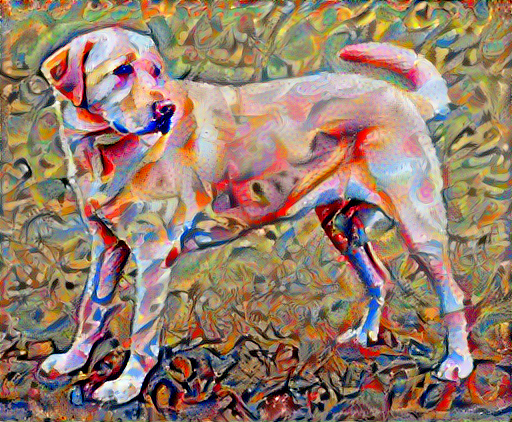

In [24]:
img_tensor, loss = run(content_tensor, style_tensor, 1000, content_weight=1e-6, style_weight=1e-2)
img = deprocess(img_tensor)
img.save("/content/dog_stylized.jpg")
img